<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 
<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" style="max-width: 150px; display: inline"  alt="Wikistat"/></a>
<a href="http://www.math.univ-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo_imt.jpg" width=400,  style="float:right;  display: inline" alt="IMT"/> </a>
    
</center>

# High Dimensional & Deep Learning : Image classification  on CatsVSDogs dataset.

### Summary

This tutorial is highly inspired by the [blog](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) from François Chollet  at the initiative of  [Keras](https://keras.io/).

## Objectives

* Use convolutional networks to  build image classifiers on colour images
* Use pre-trained models (VGG/Inception to improve the accuracy of the results)
* Fine-Tuned pre-trained models


## Libraries

In [1]:
# Utils
import sys
import os
import shutil
import time
import pickle
import numpy as np

# Deep Learning Librairies
import tensorflow as tf
import tensorflow.keras.preprocessing.image as kpi
import tensorflow.keras.layers as kl
import tensorflow.keras.optimizers as ko
import tensorflow.keras.backend as k
import tensorflow.keras.models as km
import tensorflow.keras.applications as ka

# Data visualization
from matplotlib import pyplot as plt

These code lines allow you to check if your computer is using CPU or GPU ressources. <br>
**Warning** : You won't be able to use GPU if another notebook is open and still uses GPU.

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16486114336901950017
]


2022-09-27 16:41:41.098210: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
MODE = "GPU" if "GPU" in [k.device_type for k in device_lib.list_local_devices()] else "CPU"
print(MODE)

CPU


## Dataset

The dataset used in this TP is the `CatsVSDogs` dataset used in a [Kaggle Contest](https://www.kaggle.com/c/dogs-vs-cats) which contains 25.000 images. It is a huge number when you do not have a lot of computation power. 

As our goal here is to understand behaviour of algorithms and not to achieve the best performances we have created two different subsamples of this dataset which are available in the *data* directory.

* First subsample : 100 cats images and 100 dogs images for training. 40 cats images and 40 dogs images for validation.
* Second subsample : 1000 cats images and 1000 dogs images for training. 400 cats images and 400 dogs images for validation.

### Dataset organisation

To use some of the image generators of keras, that we will use later, we have to organise the dataset so that each data of a same class are within the same folder. 

Our data are then organized this way :

```
data_dir
└───subsample/
│   └───train/
│   │   └───cats/
│   │   │   │   cat.0.jpg
│   │   │   │   cat.1.jpg
│   │   │   │   ...
│   │   └───dogs/
│   │   │   │   dog.0.jpg
│   │   │   │   dog.1.jpg
│   │   │   │   ...
│   └───validation/
│   │   └───cats/
│   │   │   │   cat.1000.jpg
│   │   │   │   cat.1000.jpg
│   │   │   │   ...
│   │   └───dogs/
│   │   │   │   dog.1000.jpg
│   │   │   │   dog.1000.jpg
│   │   │   │   ...
```

###  Parameter

In [4]:
data_dir = 'data/' # data path

# subsample directory path 

N_train = 200 #2000 
N_val = 80 #800
data_dir_sub = data_dir+'subsample_%d_Ntrain_%d_Nval' %(N_train, N_val)

### Illustration of the data

The `load_img` function allows to load an image as a PIL image.

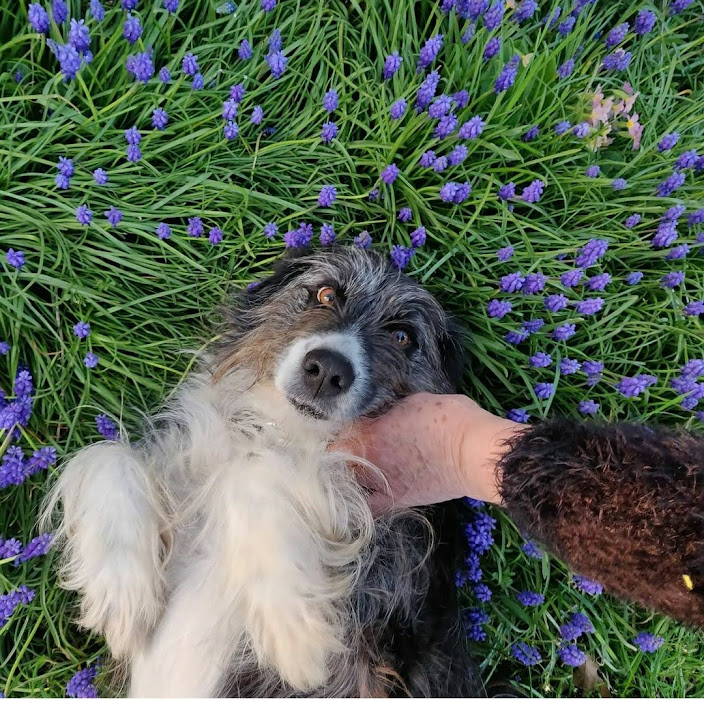

In [5]:
img = kpi.load_img(data_dir_sub+'/train/dogs/dog.0.jpg')  # this is a PIL image
img

The function `img_to_array` generates an `array numpy` from a  PIL image.

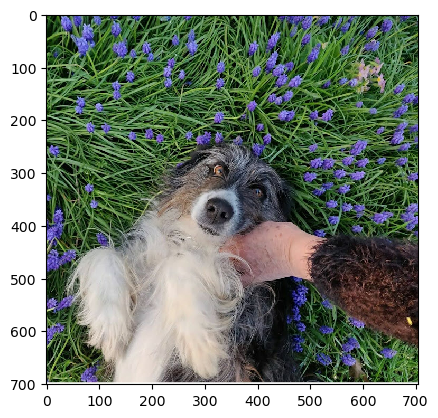

In [6]:
x = kpi.img_to_array(img)  
plt.imshow(x/255, interpolation='nearest')
plt.show()

**Q** What are the dimensions of the x array? To what correspond these dimensions?

## Pre-processing

The `ImageDataGenerator` `keras`function allows to apply different treatments on the images (transformation, normalisation). This transformation allows to produce tranformation on the images without saving a lot of changed images on the disk. The transformations make the classifier more robust.

All the possible transformations are listed in the documentation of the function.

In [7]:
kpi.ImageDataGenerator?

In [20]:
# datagen = kpi.ImageDataGenerator(
#         rotation_range=40,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True,
#         fill_mode='nearest')

datagen = kpi.ImageDataGenerator(
        rescale=1./255,
        rotation_range=40)

In oder to visualize the transformed images, we will use the`.flow()` command that generates transformed images from an original image and saves them in the specified directory.

In the following code we produce 8 of these transformed images.

In [22]:
img = kpi.load_img(data_dir_sub+"/train/cats/cat.1.jpg")  # this is a PIL image
x = kpi.img_to_array(img)  
x_ = np.expand_dims(x, axis=0)

if not(os.path.isdir(data_dir_sub+"/preprocessing_example")):
    os.mkdir(data_dir_sub+"/preprocessing_example")

    i = 0
    for batch in datagen.flow(x_, batch_size=1,save_to_dir=data_dir_sub+"/preprocessing_example", save_prefix='cat', save_format='jpeg'):
        i += 1
        if i > 7:
            break  

Display transformed images

/tmp/ipykernel_25352/4086981345.py:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_anchor" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig("cats_transformation.png", dpi=100, bbox_to_anchor="tight", facecolor=fig.get_facecolor())


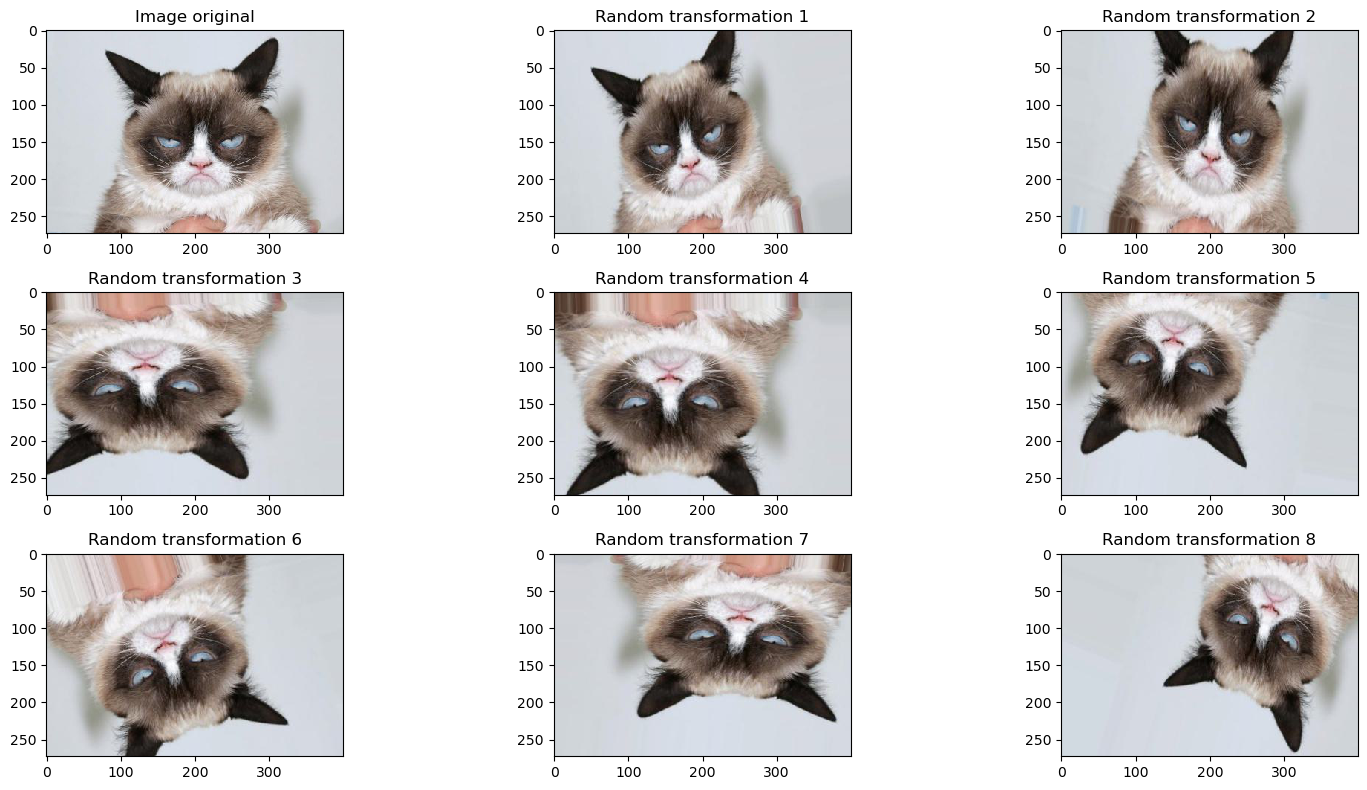

In [10]:
X_list=[]
for f in os.listdir(data_dir_sub+"/preprocessing_example"):
    X_list.append(kpi.img_to_array(kpi.load_img(data_dir_sub+"/preprocessing_example/"+f)))


fig=plt.figure(figsize=(16,8))
fig.patch.set_alpha(0)
ax = fig.add_subplot(3,3,1)
ax.imshow(x/255, interpolation="nearest")
ax.set_title("Image original")
for i,xt in enumerate(X_list):
    ax = fig.add_subplot(3,3,i+2)
    ax.imshow(xt/255, interpolation="nearest")
    ax.set_title("Random transformation %d" %(i+1))
plt.tight_layout()
plt.savefig("cats_transformation.png", dpi=100, bbox_to_anchor="tight", facecolor=fig.get_facecolor())
plt.show()

## Image classification from scratch with a convolutional network

We will here build a classifier with a custom architecture of a convolutional network.

We first define epochs and batch_size parameters.

* `epochs`: we start with a small number (5-10) in order to check that computing time is reasonable.
* `batch_size`:When using keras Generator, size of the batch should be a divider of the size of the sample, otherwise algorithms produce very unstable results.


In [11]:
epochs = 10
batch_size=20

### Data Generation

We defined two `ImageDataGenerator` objects :

* `train_datagen`: for learning, where different transformations are applied as above, in order to pass various examples to the model.
* `valid_datagen`: for validation, where only rescaling is applied.

**Question** Why do we apply different transformations for learning and validation?

Images have various dimensions :

In [12]:
x_0 = kpi.img_to_array(kpi.load_img(data_dir_sub+"/train/cats/cat.0.jpg"))
x_1 = kpi.img_to_array(kpi.load_img(data_dir_sub+"/train/cats/cat.1.jpg"))
x_0.shape, x_1.shape

((701, 526, 3), (273, 400, 3))

which is annoying because all images must have the same dimension to be used in this network. 

The `flow_from_directory` method allows to specify an output dimension in which all transformed images will be produced.

In [13]:
img_width = 150
img_height = 150

In [14]:
# this is the augmentation configuration we will use for training
train_datagen = kpi.ImageDataGenerator(
        rescale=1./255,
        rotation_range=40)

# this is the augmentation configuration we will use for testing:
# only rescaling
valid_datagen = kpi.ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        data_dir_sub+"/train/",  # this is the target directory
        target_size=(img_width, img_height),  
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = valid_datagen.flow_from_directory(
        data_dir_sub+"/validation/",
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

Found 200 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


### Model architecture

The model we define is composed of 3 convolution blocks with the following form : 

* A Conv2D layer with 32-3X3 filters and a `Relu` activation function.
* A MaxPooling layer with 2X2 window.

Followed by 


* A flatten layer.
* A Dense layer with 64 neurons and a Relu activation function.
* A Dropout layer with a 50% drop rate.
* A Dense layer with 1 neuron and a softmax activation function.

In [15]:
model_conv = km.Sequential()
model_conv.add(kl.Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3), data_format="channels_last"))
model_conv.add(kl.Activation('relu'))
model_conv.add(kl.MaxPooling2D(pool_size=(2, 2)))

model_conv.add(kl.Conv2D(32, (3, 3)))
model_conv.add(kl.Activation('relu'))
model_conv.add(kl.MaxPooling2D(pool_size=(2, 2)))

model_conv.add(kl.Conv2D(64, (3, 3)))
model_conv.add(kl.Activation('relu'))
model_conv.add(kl.MaxPooling2D(pool_size=(2, 2)))

model_conv.add(kl.Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_conv.add(kl.Dense(64))
model_conv.add(kl.Activation('relu'))
model_conv.add(kl.Dropout(0.5))
model_conv.add(kl.Dense(1))
model_conv.add(kl.Activation('sigmoid'))

model_conv.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        1

2022-09-27 16:41:43.507820: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-27 16:41:43.508084: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


As our problem here is a two classes classifier we will use the `binary_crossentropy` loss function.

In [16]:
model_conv.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])



#### Training

The training can then be done by using the `fit_generator` function instead of the `fit` function used in the MNIST notebook. This function can be used by passing generator object instead of the data to the function

In [34]:
ts = time.time()
model_conv.fit_generator(train_generator, steps_per_epoch=N_train // batch_size, epochs=epochs, 
                         validation_data=validation_generator,validation_steps=N_val // batch_size)
te = time.time()
t_learning_conv_simple_model = te-ts
print("Learning Time for %d epochs : %d seconds"%(epochs,t_learning_conv_simple_model))


/usr/local/insa/anaconda/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-09-27 16:23:15.189615: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-09-27 16:23:15.211916: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3199980000 Hz


Epoch 1/10
10/10 [==============================] - 9s 741ms/step - loss: 1.1144 - accuracy: 0.4424 - val_loss: 0.6942 - val_accuracy: 0.5000
Epoch 2/10
10/10 [==============================] - 5s 471ms/step - loss: 0.6970 - accuracy: 0.4907 - val_loss: 0.6929 - val_accuracy: 0.5375
Epoch 3/10
10/10 [==============================] - 5s 484ms/step - loss: 0.6942 - accuracy: 0.5097 - val_loss: 0.6911 - val_accuracy: 0.5000
Epoch 4/10
10/10 [==============================] - 5s 453ms/step - loss: 0.6935 - accuracy: 0.4584 - val_loss: 0.6915 - val_accuracy: 0.5625
Epoch 5/10
10/10 [==============================] - 5s 509ms/step - loss: 0.6856 - accuracy: 0.5924 - val_loss: 0.6877 - val_accuracy: 0.5000
Epoch 6/10
10/10 [==============================] - 5s 474ms/step - loss: 0.7032 - accuracy: 0.5166 - val_loss: 0.6883 - val_accuracy: 0.5125
Epoch 7/10
10/10 [==============================] - 5s 491ms/step - loss: 0.6773 - accuracy: 0.5793 - val_loss: 0.6854 - val_accuracy: 0.5000
Epoch 

#### Prediction

In [35]:
ts = time.time()
score_conv_val = model_conv.evaluate_generator(validation_generator, N_val /batch_size, verbose=1)
score_conv_train = model_conv.evaluate_generator(train_generator, N_train / batch_size, verbose=1)
te = time.time()
t_prediction_conv_simple_model = te-ts
print('Train accuracy:', score_conv_train[1])
print('Validation accuracy:', score_conv_val[1])
print("Time Prediction: %.2f seconds" %t_prediction_conv_simple_model )

/usr/local/insa/anaconda/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


10/10 [==============================] - 3s 313ms/step - loss: 0.6597 - accuracy: 0.6850
Train accuracy: 0.6850000023841858
Validation accuracy: 0.675000011920929
Time Prediction: 4.19 seconds


**Q** Compare the accuracy and loss values for training and validation to the ones observed in the last epochs of training. What do you observe? Is this normal ?<br>
Meilleure accuracy pour le training car l'algo s'est spécialisé pour le training

**Q** What can you say about the performance of this model?
Mieux qu'un pile ou face donc c'est déjà pas mal mais c'est pas dingue

**Exercice** Add more transformation to the learning generator. Does this help?

## Pre-trained Network

We have seen above that the complexity of the data makes it difficult to build quickly an efficient classifier from scratch even  with an elaborate method as a convolutional network.

We will now see that this problem can easily be tackled by using **pre-trained models**. These models are models that are very complex (see image below). They have been trained on a very huge amount of image data in order to classify them. 

The figure below represents a *VGG 16*. This model is composed of *5 convolutional blocks* which allows to build features on the images. The last block is a *fully convolutional block*. This last block can be seen as a simple *MLP model* which is used on the features build by the convolutional block.

How this model, designed to solve a different problem that our problem can be helpfull?

Here is our two-stage strategy :  
1. We will send our data through the 5 convolutional blocks in order to build features. These blocks have been trained on a huge amount of data and can then build intelligent features.
2. We will build our own MLP classifier designed to solve our CatsVsDogs problem, and we will train it on the features built on the first step.


### Network illustration

![](https://blog.keras.io/img/imgclf/vgg16_original.png)

### Step 1 : Build features

#### Download  the weights of the 5 blocks convolutional layer.

We will now download the weights of a VGG16 model that has been learned on the [image-net](http://www.image-net.org) dataset. The image-net is composed of millions of images for 1000 categories.

If it's the first time you use these weights, you will have to download it (it will start automatically) and they will be save in your home 
`"~/.keras/models"`

The *include_top* argument of the `VGG16` application allows to precise if we want to use or not the last block (fully-connected later)


In [23]:
model_VGG16_without_top = ka.VGG16(include_top=False, weights='imagenet')
model_VGG16_without_top.summary()

58892288/58889256 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

#### Building features

We will now send our data to the loaded model in order to build our features.

In [24]:
datagen = kpi.ImageDataGenerator(rescale=1. / 255)

generator = datagen.flow_from_directory(
        data_dir_sub+"/train",
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,  # this means our generator will only yield batches of data, no labels
        shuffle=False)  
features_train = model_VGG16_without_top.predict_generator(generator, N_train / batch_size,  verbose = 1)


generator = datagen.flow_from_directory(
    data_dir_sub+"/validation",
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
features_validation = model_VGG16_without_top.predict_generator(generator, N_val / batch_size,  verbose = 1)    

Found 200 images belonging to 2 classes.


/usr/local/insa/anaconda/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
2022-09-27 16:46:43.824405: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-09-27 16:46:43.844393: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3199980000 Hz


10/10 [==============================] - 12s 1s/step
Found 80 images belonging to 2 classes.
4/4 [==============================] - 4s 1s/step


### Step 2 :  Building our classifier on top of features

We will now build a simple classifier in order to use the previously build features to classify our data.


#### Training
**Exercise** Write this classifier 

In [35]:
model_VGG_fcm = km.Sequential()
model_VGG_fcm.add(kl.Flatten(input_shape=features_train.shape[1:]))
model_VGG_fcm.add(kl.Dense(64, activation='relu'))
model_VGG_fcm.add(kl.Dropout(0.5))
model_VGG_fcm.add(kl.Dense(1, activation='sigmoid'))

model_VGG_fcm.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_VGG_fcm.summary()


train_labels = np.array([0] * int((N_train/2)) + [1] * int((N_train/2)))
validation_labels = np.array([0] * int((N_val/2)) + [1] * int((N_val/2)))

model_VGG_fcm.fit(features_train, train_labels,
          epochs=epochs,
          batch_size=batch_size,
          validation_data=(features_validation, validation_labels))
t_learning_VGG_fcm = te-ts

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 64)                524352    
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 65        
Total params: 524,417
Trainable params: 524,417
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
10/10 [==============================] - 1s 48ms/step - loss: 1.4462 - accuracy: 0.5171 - val_loss: 0.4266 - val_accuracy: 0.8125
Epoch 2/10
10/10 [==============================] - 0s 22ms/step - loss: 0.5541 - accuracy: 0.7389 - val_

We now save the weights of this classifier to be used later.

### Prediction

In [36]:
ts = time.time()
score_VGG_fcm_val = model_VGG_fcm.evaluate(features_validation, validation_labels)
score_VGG_fcm_train = model_VGG_fcm.evaluate(features_train, train_labels)
te = time.time()
t_prediction_VGG_fcm = te-ts
print('Train accuracy:', score_VGG_fcm_train[1])
print('Validation accuracy:', score_VGG_fcm_val[1])
print("Time Prediction: %.2f seconds" %t_prediction_VGG_fcm)

7/7 [==============================] - 0s 4ms/step - loss: 0.0203 - accuracy: 1.0000
Train accuracy: 1.0
Validation accuracy: 0.9375
Time Prediction: 0.36 seconds


**Q** Comment the performance of this new model

In [37]:
model_VGG_fcm.save_weights(data_dir_sub+'/weights_model_VGG_fully_connected_model_%d_epochs_%d_batch_size.h5' %(epochs, batch_size))

## Fine Tuning

We have notably increased the performances of our model with a model that is really quick. We can continue to try to improve our results by modifying the small MLP classifier network we build. 
 
But to really improve our model, it would be nice to also change the weights of the previous layers in order to make them fit our problem.
This is possible and it's called FineTuning.

In this part we will then build a Model which is composed of the 5 convolutional block of the VGG model (with its weights learned on Image Net) and the classifier block we built (with the weights that we have learned previously).

![](https://blog.keras.io/img/imgclf/vgg16_modified.png)

### Model creation.

We first download the model as done previously.

However, the model will be trained on our images, we then have to specify the input_shape of our data.


In [38]:
# build the VGG16 network
model_VGG16_without_top = ka.VGG16(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3))
print('Model loaded.')

Model loaded.


We then build a classfier model like the one we built above and we load the learned weights.

In [39]:
# build a classifier model to put on top of the convolutional model
top_model = km.Sequential()
top_model.add(kl.Flatten(input_shape=model_VGG16_without_top.output_shape[1:]))
top_model.add(kl.Dense(64, activation='relu'))
top_model.add(kl.Dropout(0.5))
top_model.add(kl.Dense(1, activation='sigmoid'))

top_model.load_weights(data_dir_sub+'/weights_model_VGG_fully_connected_model_%d_epochs_%d_batch_size.h5' %(epochs, batch_size))


Finally we assemble these two models

In [40]:
# add the model on top of the convolutional base
model_VGG_LastConv_fcm = km.Model(inputs=model_VGG16_without_top.input, outputs=top_model(model_VGG16_without_top.output))

model_VGG_LastConv_fcm.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

### Freezed block

Our model is ready to be fine-tuned! 

However, as seen above it contains a huge number of parameters that our computer may not handle.

We will start by fine-tune only the last block of convolution of our classifier. 

This is possible by updating the trainable arguments of the layers that we don't want to be updated.

In [41]:
for layer in model_VGG_LastConv_fcm.layers[:15]:
    layer.trainable = False

### Generate Data

In [42]:
# prepare data augmentation configuration
train_datagen = kpi.ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = kpi.ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    data_dir_sub+"/train/",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    data_dir_sub+"/validation/",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')


Found 200 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


### Training

In [43]:
model_VGG_LastConv_fcm.compile(loss='binary_crossentropy',
              optimizer=ko.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])


# fine-tune the model
ts = time.time()
model_VGG_LastConv_fcm.fit_generator(
    train_generator,
    steps_per_epoch=N_train // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=N_val // batch_size)
te = time.time()
t_learning_VGG_LastConv_fcm = te-ts


/usr/local/insa/anaconda/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
10/10 [==============================] - 22s 2s/step - loss: 0.2261 - accuracy: 0.8851 - val_loss: 0.1958 - val_accuracy: 0.9375
Epoch 2/10
10/10 [==============================] - 21s 2s/step - loss: 0.2328 - accuracy: 0.9042 - val_loss: 0.1894 - val_accuracy: 0.9250
Epoch 3/10
10/10 [==============================] - 21s 2s/step - loss: 0.1986 - accuracy: 0.9116 - val_loss: 0.1965 - val_accuracy: 0.9375
Epoch 4/10
10/10 [==============================] - 20s 2s/step - loss: 0.1801 - accuracy: 0.8972 - val_loss: 0.1793 - val_accuracy: 0.9250
Epoch 5/10
10/10 [==============================] - 19s 2s/step - loss: 0.1681 - accuracy: 0.9228 - val_loss: 0.1705 - val_accuracy: 0.9500
Epoch 6/10
10/10 [==============================] - 18s 2s/step - loss: 0.1396 - accuracy: 0.9393 - val_loss: 0.1884 - val_accuracy: 0.9375
Epoch 7/10
10/10 [==============================] - 18s 2s/step - loss: 0.1329 - accuracy: 0.9389 - val_loss: 0.1676 - val_accuracy: 0.9375
Epoch 8/10
10/10 [==

###  Prediction

In [44]:
ts = time.time()
score_VGG_LastConv_fcm_val = model_VGG_LastConv_fcm.evaluate_generator(validation_generator, N_val // batch_size, verbose=1)
score_VGG_LastConv_fcm_train = model_VGG_LastConv_fcm.evaluate_generator(train_generator, N_train // batch_size, verbose=1)

te = time.time()
t_prediction_VGG_LastConv_fcm = te-ts
print('Train accuracy:', score_VGG_LastConv_fcm_val[1])
print('Validation accuracy:', score_VGG_LastConv_fcm_train[1])
print("Time Prediction: %.2f seconds" %t_prediction_VGG_LastConv_fcm)

/usr/local/insa/anaconda/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


10/10 [==============================] - 11s 1s/step - loss: 0.0958 - accuracy: 0.9650
Train accuracy: 0.925000011920929
Validation accuracy: 0.9649999737739563
Time Prediction: 15.79 seconds


## Prediction on Kaggle Dataset

Let's see now how our trained model performs on the kaggle real test dataset (data/test)

**Exercise** Apply the model to this dataset and display results on a sample to check it performs well

Found 200 images belonging to 1 classes.


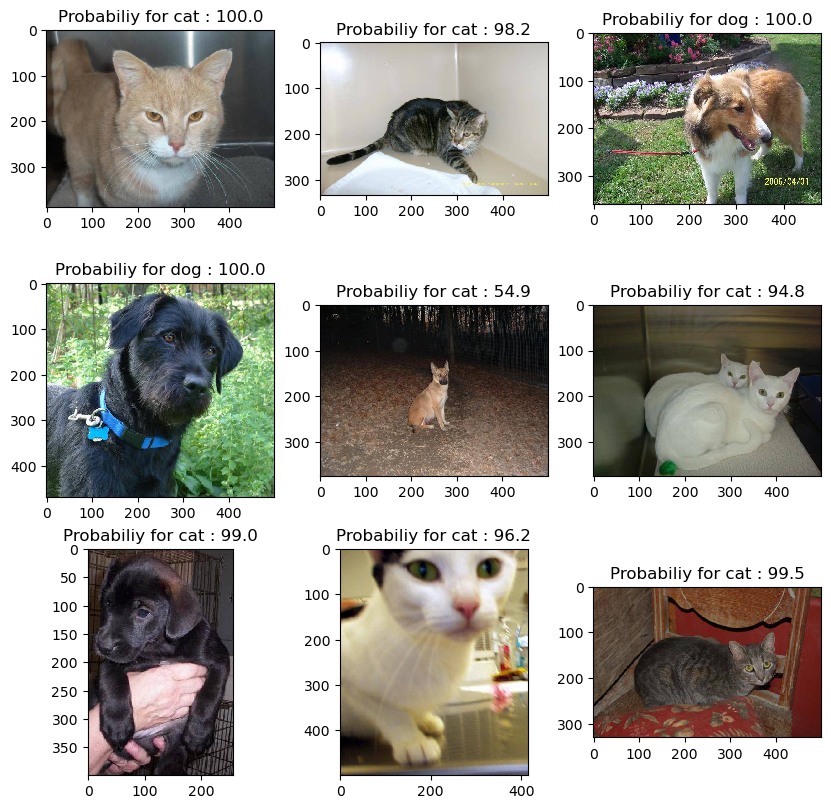

In [47]:
data_dir_test = data_dir+'test/'
N_test = len(os.listdir(data_dir_test+"/test"))

test_datagen = kpi.ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    data_dir_test,
    #data_dir_sub+"/train/",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

test_prediction = model_VGG_LastConv_fcm.predict_generator(test_generator, N_test // batch_size)

images_test = [data_dir_test+"/test/"+k for k in os.listdir(data_dir_test+"/test")][:9]
x_test  = [kpi.img_to_array(kpi.load_img(image_test))/255 for image_test in images_test]  # this is a PIL image

fig = plt.figure(figsize=(10,10))
for k in range(9):
    ax = fig.add_subplot(3,3,k+1)
    ax.imshow(x_test[k], interpolation='nearest')
    pred = test_prediction[k]
    if pred >0.5:
        title = "Probabiliy for dog : %.1f" %(pred*100)
    else:
        title = "Probabiliy for cat : %.1f" %((1-pred)*100)
    ax.set_title(title)
plt.show()

## Exercise

Keras has a lot of pre-trained model

* Xception
* VGG16
* VGG19
* ResNet50
* InceptionV3
* InceptionResNetV2
* MobileNet

Some have a much more complex architecture like `InceptionV3`.

**Exercice** Restart the TP by using a different pre-trained model and apply the required modifications.